# Part 3 - The COS-method

In [33]:
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import norm

In [34]:
def BS_valuation(S, T, r, K, sigma):
    # Black-Scholes formula for European option prices
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [20]:
def chi(n, a, b):
    return (np.exp(b) * np.cos(n * np.pi) - 
            np.cos(n * np.pi * a / (b - a)) + 
            n * np.pi / (b - a) * np.sin(n * np.pi * a / (b - a))) / (1 + (n * np.pi / (b - a))**2)

def psi(n, a, b):
    if n == 0:
        return b
    return (b - a) / (n * np.pi) * np.sin(n * np.pi * a / (b - a))

def G(n, a, b, K):
    return 2 * K / (b - a) * (chi(n, a, b) - psi(n, a, b))

def char_func_y(x, u, r, sigma, T):
    return np.exp(1j * u * (x + (r - 0.5 * sigma**2) * T) - 0.5 * T * sigma**2 * u**2)

def F(n, a, b, x, r, sigma, T):
    return np.real( char_func_y(x=x, u = n*np.pi / (b-a), r=r, sigma=sigma, T=T) * np.exp(-1j * n * np.pi * a / (b - a)))

def solve_COS_method(S0, K, T, r, sigma, N, a, b):
    x = np.log(S0 / K)
    
    V = 1/2 * F(0, a, b, x, r, sigma, T) * G(0, a, b, K)
    for n in range(1, N):
        V += F(n, a, b, x, r, sigma, T) * G(n, a, b, K)
    
    V *= np.exp(-r * T)

    return V

In [47]:
def calc_error(S0, K, T, r, sigma, N, a, b):
    V_BS = BS_valuation(S0, T, r, K, sigma)
    V_COS = solve_COS_method(S0, K, T, r, sigma, N, a, b)
    return np.abs(V_BS - V_COS)

With S0: 100, Option Price (COS): 9.625357828843628, analytical: 9.625357828843697
With S0: 110, Option Price (COS): 15.128591111967848, analytical: 15.128591111967928
With S0: 120, Option Price (COS): 21.7888083388292, analytical: 21.788808338829327


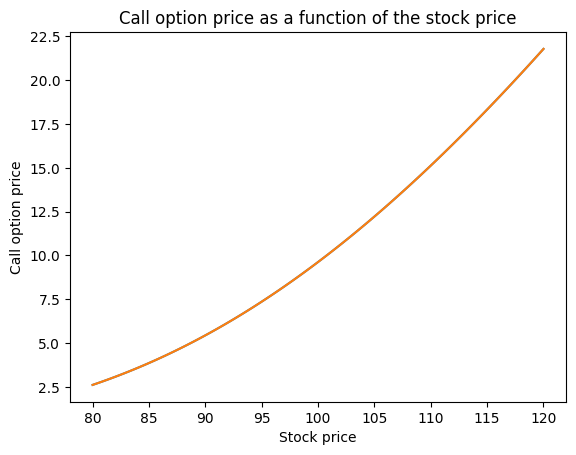

In [43]:
K = 110
T = 1
r = 0.04
sigma = 0.3
N = 64
a = -3
b = 3

for S0 in [100, 110, 120]:
    print(f"With S0: {S0}, Option Price (COS): {solve_COS_method(S0, K, T, r, sigma, N, a, b)}, analytical: {BS_valuation(S0, T, r, K, sigma)}")

# Plot the price of the call option as a function of the stock price

S0 = np.linspace(80, 120, 100)
price_COS = [solve_COS_method(s, K, T, r, sigma, N, a, b) for s in S0]
price_analytical = [BS_valuation(s, T, r, K, sigma) for s in S0]

plt.plot(S0, price_COS, label="COS method")
plt.plot(S0, price_analytical, label="Analytical")
plt.xlabel("Stock price")
plt.ylabel("Call option price")
plt.title("Call option price as a function of the stock price")
plt.show()

## Finding values for $a$ and $b$

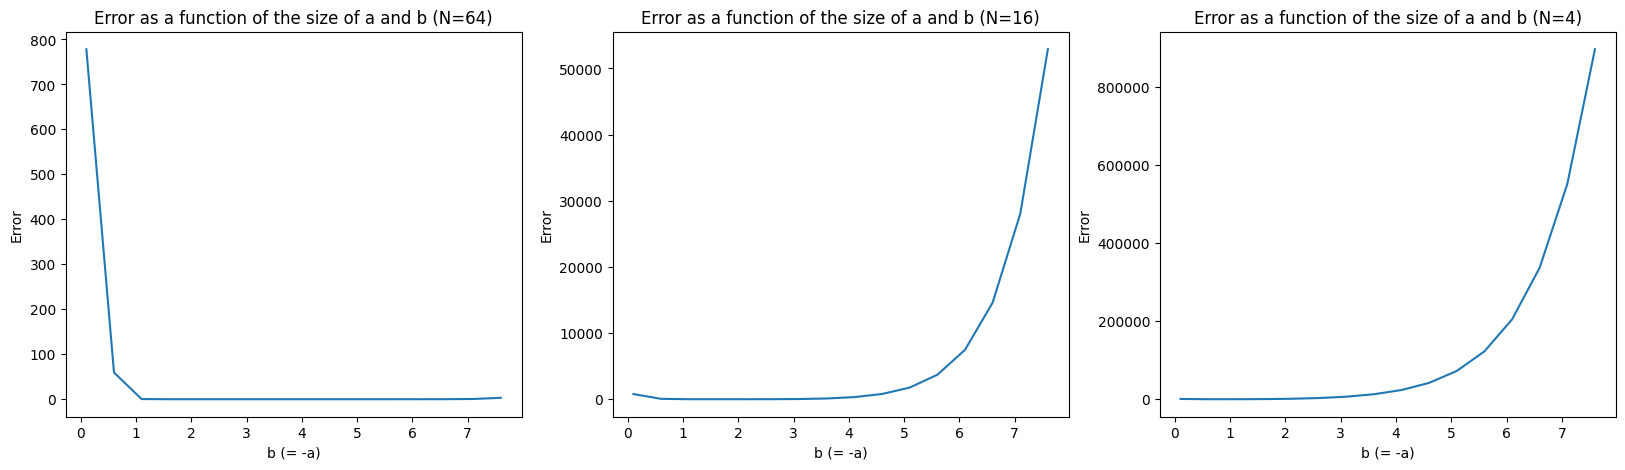

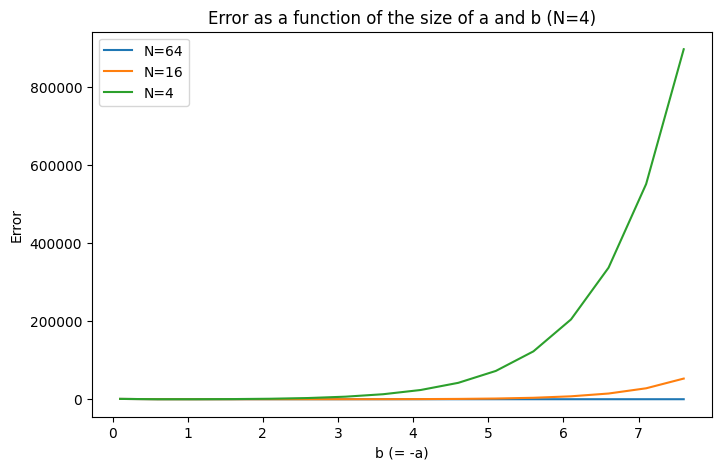

In [72]:
K = 110
T = 1
r = 0.04
sigma = 0.3
N = 64
S0_values = np.linspace(80, 120, 100)

offsets_ab = np.arange(0.1, 8, 0.5)


N_values = [64, 16, 4]

fig1, ax1 = plt.subplots(1, 3, figsize=(20, 5))
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 5))

for N in N_values:
    errors = []
    for offset in offsets_ab:
        a = -offset
        b = offset
        error = np.sum([calc_error(S0, K, T, r, sigma, N, a, b) for S0 in S0_values])
        errors.append(error)
    ax1[N_values.index(N)].plot(offsets_ab, errors, label="Error")
    ax1[N_values.index(N)].set_xlabel("b (= -a)")
    ax1[N_values.index(N)].set_ylabel("Error")
    ax1[N_values.index(N)].set_title(f"Error as a function of the size of a and b (N={N})")

    ax2.plot(offsets_ab, errors, label=f"N={N}")

ax2.set_xlabel("b (= -a)")
ax2.set_ylabel("Error")
ax2.set_title(f"Error as a function of the size of a and b (N={N})")
ax2.legend()
plt.show()

## Change $b$ independently from $a$

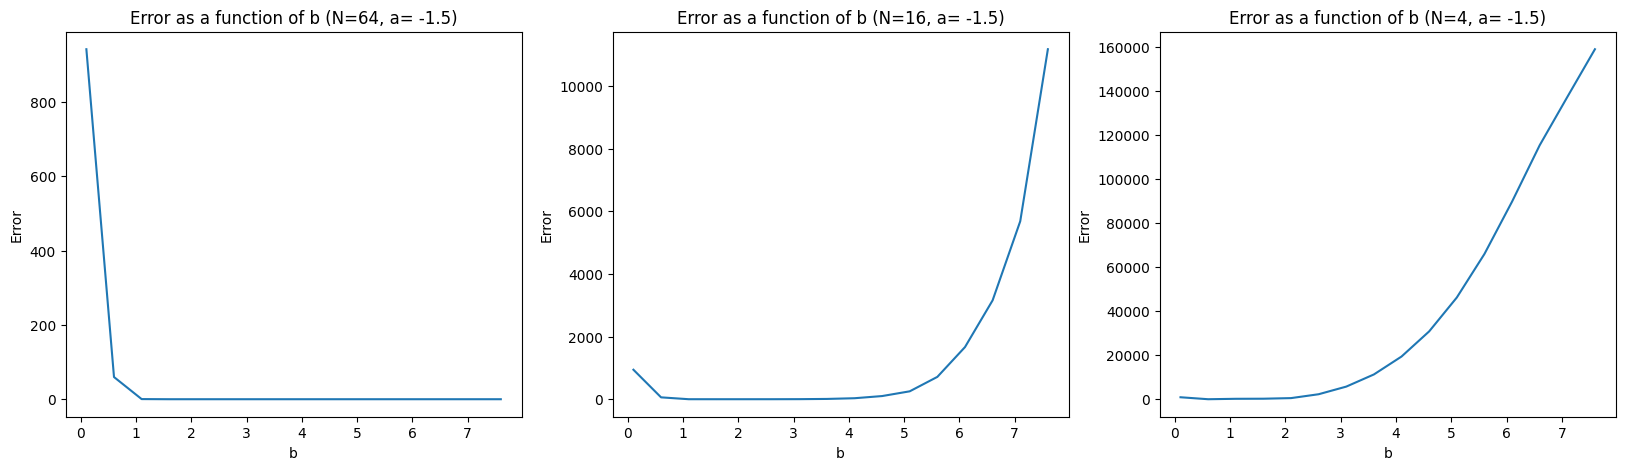

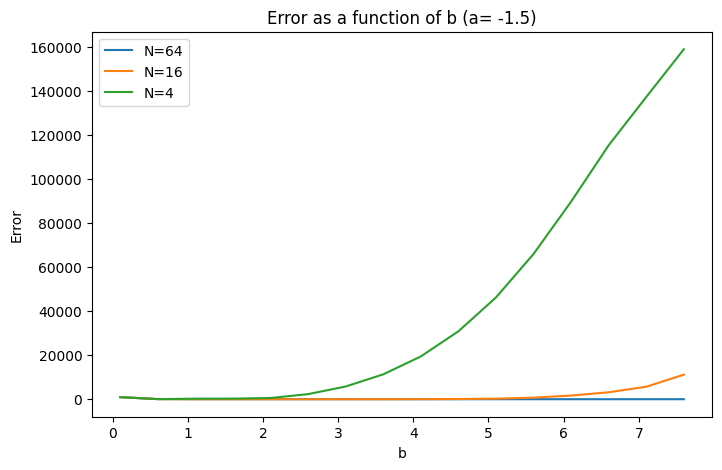

In [74]:
K = 110
T = 1
r = 0.04
sigma = 0.3
S0_values = np.linspace(80, 120, 100)

a = -1.5
b_values = np.arange(0.1, 8, 0.5)

N_values = [64, 16, 4]

fig1, ax1 = plt.subplots(1, 3, figsize=(20, 5))
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 5))

for N in N_values:
    errors = []
    for b in b_values:
        error = np.sum([calc_error(S0, K, T, r, sigma, N, a, b) for S0 in S0_values])
        errors.append(error)
    ax1[N_values.index(N)].plot(b_values, errors, label="Error")
    ax1[N_values.index(N)].set_xlabel("b")
    ax1[N_values.index(N)].set_ylabel("Error")
    ax1[N_values.index(N)].set_title(f"Error as a function of b (N={N}, a= {a})")

    ax2.plot(b_values, errors, label=f"N={N}")

ax2.set_xlabel("b")
ax2.set_ylabel("Error")
ax2.set_title(f"Error as a function of b (a= {a})")
ax2.legend()
plt.show()

## Change $N$

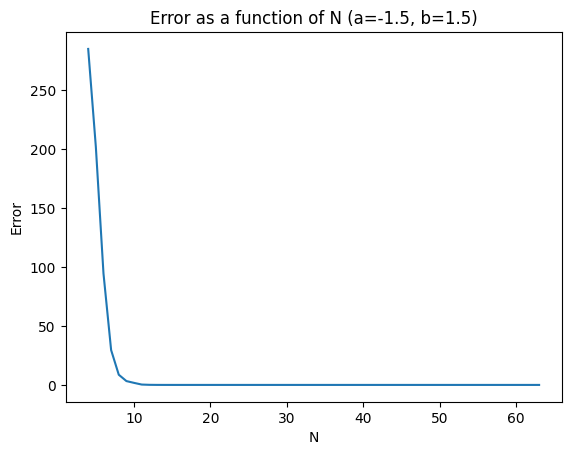

In [75]:
K = 110
T = 1
r = 0.04
sigma = 0.3
a = -1.5
b = 1.5
S0_values = np.linspace(80, 120, 100)


N_values = np.arange(4, 64, 1)

errors = []
for N in N_values:
    error = np.sum([calc_error(S0, K, T, r, sigma, N, a, b) for S0 in S0_values])
    errors.append(error)

plt.plot(N_values, errors, label="Error")
plt.xlabel("N")
plt.ylabel("Error")
plt.title(f"Error as a function of N (a={a}, b={b})")
plt.show()